In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataTransformation import LowPassFilter
from scipy.signal import argrelextrema
from sklearn.metrics import mean_absolute_error

In [10]:
pd.options.mode.chained_assignment = None

# Plot settings
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

# 1. Đọc file dữ liệu

In [38]:
df = pd.read_pickle("../../data/interim/01_data_processed.pkl")
df = df[df["label"] != "rest"]

acc_r = df["acc_x"] ** 2 + df["acc_y"] ** 2 + df["acc_z"] ** 2
gyr_r = df["gyr_x"] ** 2 + df["gyr_y"] ** 2 + df["gyr_z"] ** 2
df["acc_r"] = np.sqrt(acc_r)
df["gyr_r"] = np.sqrt(gyr_r)

# 2. Tạo các dataframe cho từng bài tập

In [39]:
bench_df = df[df["label"] == "bench"]
squat_df = df[df["label"] == "squat"]
row_df = df[df["label"] == "row"]
ohp_df = df[df["label"] == "ohp"]
dead_df = df[df["label"] == "dead"]

# 3. Chọn đặc trưng đếm đỉnh
(Sau khi xem xét các biểu đồ thì acc_r được chọn cho cả 6 bài tập)

In [321]:
plot_df = bench_df
#plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["acc_x"].plot()
#plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["acc_y"].plot()
#plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["acc_z"].plot()
#plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["acc_r"].plot()

#plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["gyr_x"].plot()
#plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["gyr_y"].plot()
#plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["gyr_z"].plot()
#plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["gyr_r"].plot()

In [41]:
fs = 12.5
LowPass = LowPassFilter()

In [323]:
bench_set = plot_df[plot_df["set"] == bench_df["set"].unique()[0]]
squat_set = plot_df[plot_df["set"] == squat_df["set"].unique()[0]]
row_set = plot_df[plot_df["set"] == row_df["set"].unique()[0]]
ohp_set = plot_df[plot_df["set"] == ohp_df["set"].unique()[0]]
dead_set = plot_df[plot_df["set"] == dead_df["set"].unique()[0]]

<AxesSubplot: xlabel='epoch (ms)'>

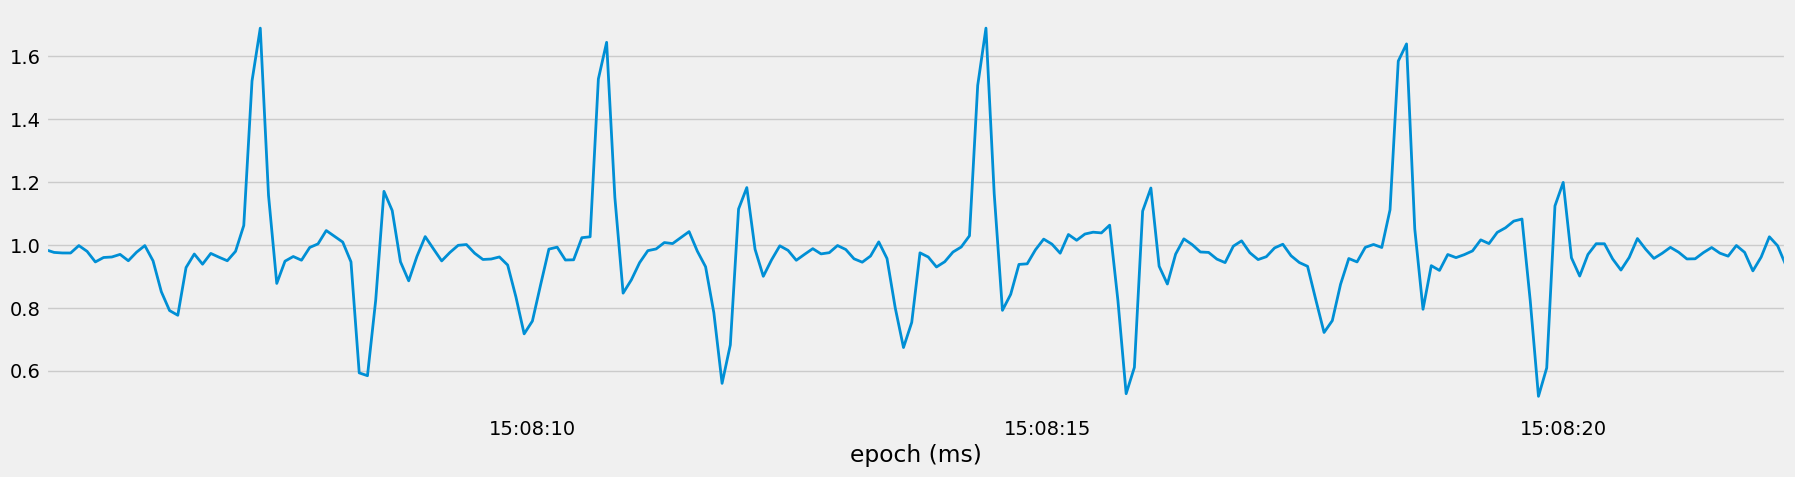

In [324]:
bench_set["acc_r"].plot()

<AxesSubplot: xlabel='epoch (ms)'>

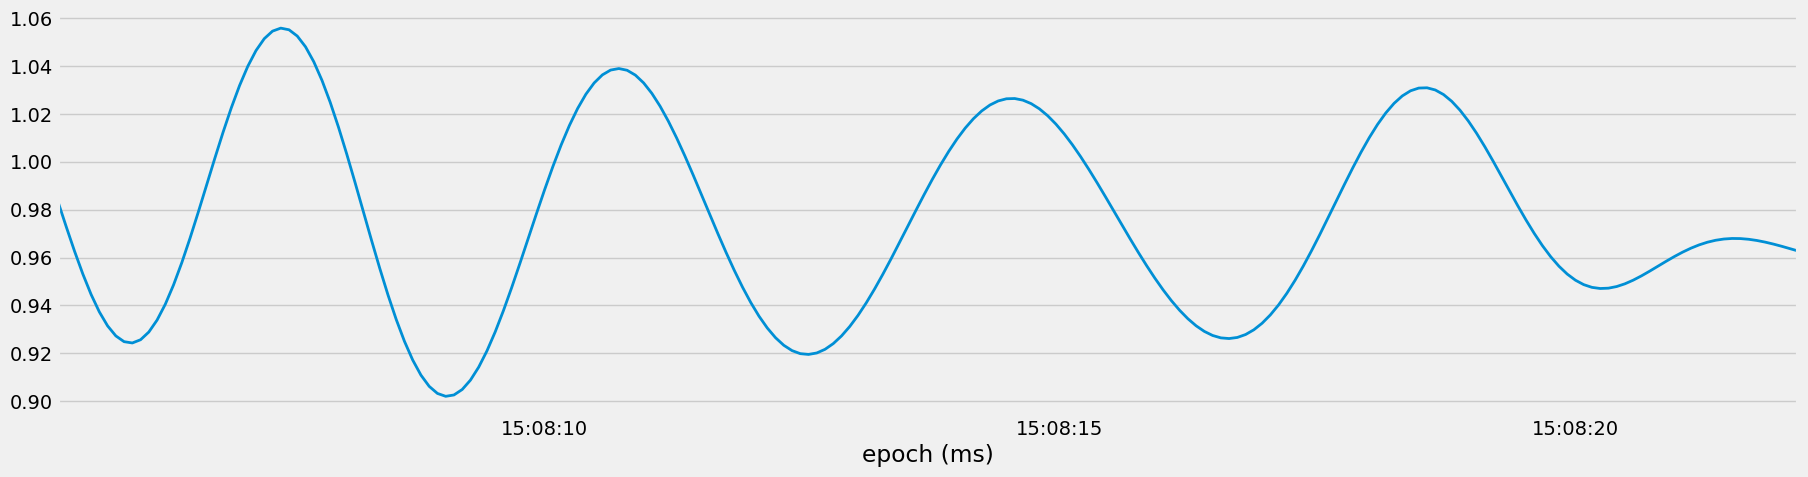

In [327]:
column = "acc_r"
LowPass.low_pass_filter(
    data_table=bench_set,
    col=column,
    sampling_frequency=fs,
    cutoff_frequency=0.4,
    order=10,
)[column + "_lowpass"].plot()

# 4. Thực hiện đếm đỉnh

In [43]:
def count_reps(dataset, cutoff=0.4, order=10, column="acc_r"):
    data = LowPass.low_pass_filter(
        data_table=dataset,
        col=column,
        sampling_frequency=fs,
        cutoff_frequency=cutoff,
        order=order,
    )
    indexes = argrelextrema(data[column + "_lowpass"].values, np.greater)
    peaks = data.iloc[indexes]

    return len(peaks)

In [45]:
count_reps(bench_set)

5

## 4.1. Thiết lập số set tập ban đầu

In [328]:
df["reps"] = df["category"].apply(lambda x : 5 if x == "heavy" else 10)
rep_df = df.groupby(["label", "category", "set"])["reps"].max().reset_index()
rep_df["reps_pred"] = 0
rep_df

,label,category,set,reps,reps_pred
0,bench,heavy,1,5,0
1,bench,heavy,2,5,0
2,bench,heavy,3,5,0
3,bench,heavy,4,5,0
4,bench,heavy,30,5,0
...,...,...,...,...,...
80,squat,medium,28,10,0
81,squat,medium,29,10,0
82,squat,medium,38,10,0
83,squat,medium,63,10,0


# 4.2. Tinh chỉnh hệ số cutoff cho từng bài tập và mức tạ

In [624]:
for s in df["set"].unique():
    subset = df[df["set"] == s]
    
    column = "acc_r"
    cutoff = 0.4

    if subset["label"].iloc[0] == "bench":
        if subset["category"].iloc[0] == "heavy":
            cutoff = 0.45
        else:
            cutoff = 0.43
        
    if subset["label"].iloc[0] == "squat":
        if subset["category"].iloc[0] == "heavy":
            cutoff = 0.45
        else:
            cutoff = 0.5595
        
    if subset["label"].iloc[0] == "row":
        if subset["category"].iloc[0] == "heavy":
            cutoff = 0.592
        else: 
            cutoff = 0.498
            
    if subset["label"].iloc[0] == "ohp":
        if subset["category"].iloc[0] == "heavy":
            cutoff = 0.442
        else:
            cutoff = 0.65
    
    if subset["label"].iloc[0] == "dead":
        if subset["category"].iloc[0] == "medium":
            cutoff = 0.3961037105

    reps = count_reps(subset, cutoff=cutoff, column=column)
    
    rep_df.loc[rep_df["set"] == s, "reps_pred"] = reps


## 4.3. Kiểm tra kết quả

In [625]:
rep_bench = rep_df[rep_df["label"] == "bench"]
rep_bench

,label,category,set,reps,reps_pred
0,bench,heavy,1,5,5
1,bench,heavy,2,5,5
2,bench,heavy,3,5,5
3,bench,heavy,4,5,5
4,bench,heavy,30,5,5
5,bench,heavy,31,5,5
6,bench,heavy,39,5,5
7,bench,heavy,40,5,5
8,bench,heavy,41,5,5
9,bench,heavy,65,5,5


In [626]:
rep_ohp = rep_df[rep_df["label"] == "ohp"]
rep_ohp

,label,category,set,reps,reps_pred
30,ohp,heavy,9,5,6
31,ohp,heavy,10,5,4
32,ohp,heavy,11,5,6
33,ohp,heavy,12,5,5
34,ohp,heavy,13,5,5
35,ohp,heavy,14,5,5
36,ohp,heavy,32,5,5
37,ohp,heavy,33,5,6
38,ohp,heavy,34,5,5
39,ohp,heavy,45,5,4


In [627]:
rep_squat = rep_df[rep_df["label"] == "squat"]
rep_squat

,label,category,set,reps,reps_pred
70,squat,heavy,24,5,4
71,squat,heavy,25,5,5
72,squat,heavy,26,5,5
73,squat,heavy,53,5,5
74,squat,heavy,54,5,6
75,squat,heavy,55,5,5
76,squat,heavy,62,5,5
77,squat,heavy,92,5,5
78,squat,heavy,93,5,5
79,squat,medium,27,10,6


In [628]:
rep_row = rep_df[rep_df["label"] == "row"]
rep_row

,label,category,set,reps,reps_pred
50,row,heavy,22,5,5
51,row,heavy,23,5,5
52,row,heavy,47,5,5
53,row,heavy,48,5,5
54,row,heavy,49,5,6
55,row,heavy,50,5,6
56,row,heavy,83,5,5
57,row,heavy,84,5,5
58,row,heavy,85,5,5
59,row,heavy,86,5,5


In [629]:
rep_dead = rep_df[rep_df["label"] == "dead"]
rep_dead

,label,category,set,reps,reps_pred
19,dead,heavy,5,5,5
20,dead,heavy,72,5,5
21,dead,medium,6,10,9
22,dead,medium,7,10,10
23,dead,medium,8,10,11
24,dead,medium,42,10,10
25,dead,medium,43,10,10
26,dead,medium,44,10,11
27,dead,medium,73,10,9
28,dead,medium,74,10,10


In [630]:
error = mean_absolute_error(rep_df["reps"], rep_df["reps_pred"]).round(2)
error

0.54

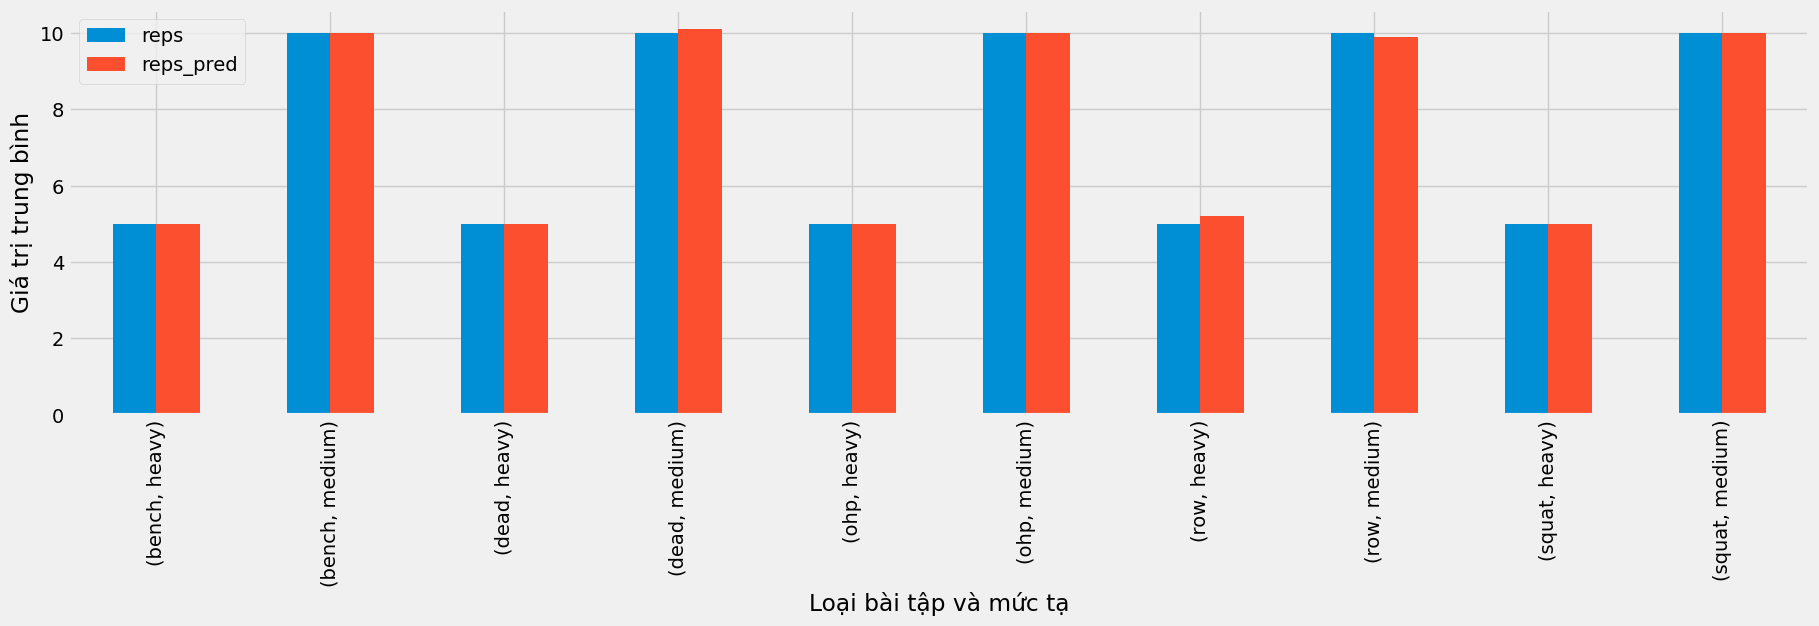

In [634]:
grouped_data = rep_df.groupby(["label", "category"])[["reps", "reps_pred"]].mean()

ax = grouped_data.plot.bar()
ax.set_xlabel("Loại bài tập và mức tạ")
ax.set_ylabel("Giá trị trung bình") 
plt.show()